In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [3]:
from functions import *

In [4]:
from algorithms_comp import *

In [5]:
%load_ext autoreload

In [6]:
%aimport algorithms_comp
%aimport -algorithms_comp
%aimport algorithms_comp

In [7]:
from utils import *

# Logistic regression

## Diabetes

In [8]:
%%time
dataset = "diabetes"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  768 , dimension of the problem:  8
Smoothness constant of the sum:  8606.92253909742
Average smoothness constant   :  10862.250377252869
Worst smoothness constant     :  189988.542101
Fraction of non-zero elemenst :  0.8758138020833334
CPU times: total: 0 ns
Wall time: 18 ms


### Find the solution

In [9]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [10]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.6084979240101024
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.6084979240101024
        x: [-1.284e-01 -1.294e-02  3.033e-02 -1.956e-04 -7.389e-04
             4.814e-03 -3.203e-01  1.563e-02]
      nit: 84
      jac: [-1.617e-06  2.453e-05  2.518e-05  1.565e-05  6.906e-05
             1.449e-05  3.192e-07  1.009e-05]
     nfev: 101
     njev: 101
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 21 ms


In [11]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [12]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 200

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 1
x_init[0:num_of_non_zeros] += shift_param
N = 10000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-1
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-4

f(x_0)-f(x^*) =  1.269398056499138


# Tests for ZO-AccSGD

Tuning learning rate and batchsize

In [21]:
%%time
step_param = 1
Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
print('Finished with lr = {} and bs = {}'.format(step_param, bs))

100%|██████████| 38400/38400 [03:17<00:00, 193.97it/s]

Finished with lr = 1 and bs = 200
CPU times: total: 3min 18s
Wall time: 3min 17s


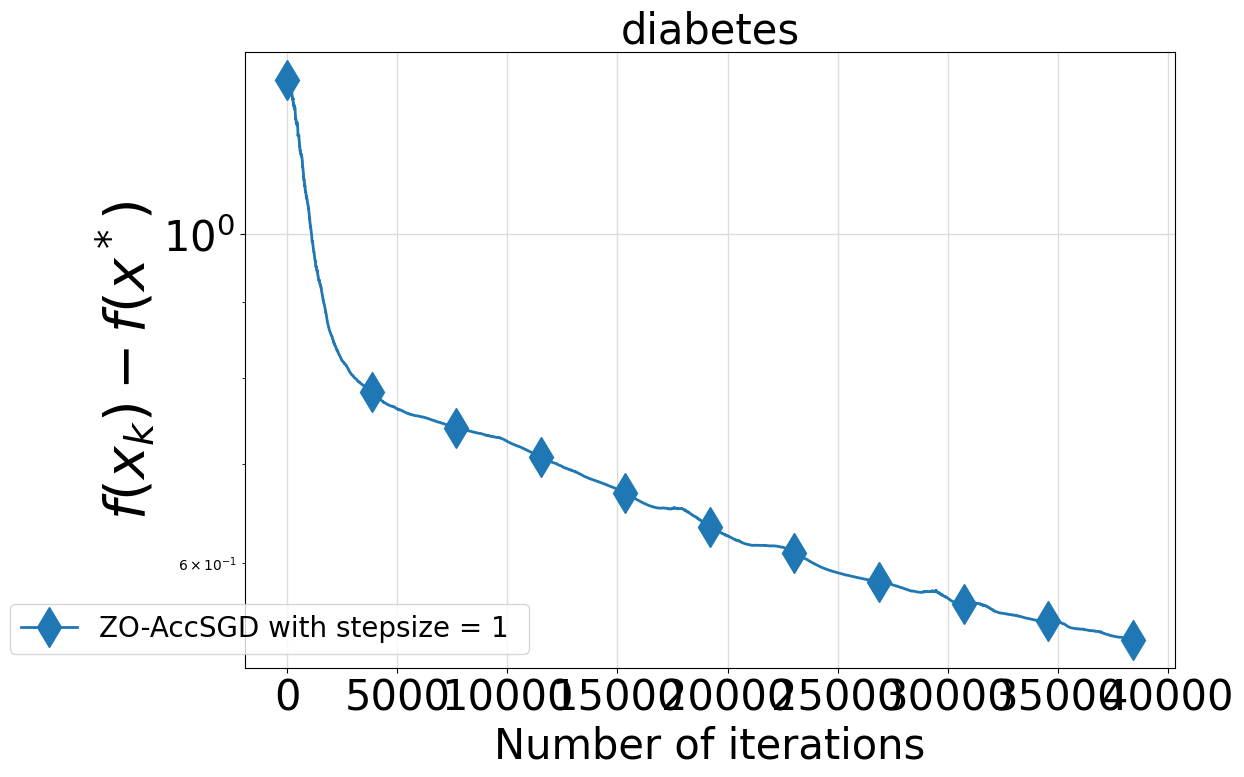

In [22]:
method = []
method.append(['Our_algorithm logreg', [step_param, N, delta, bs], f"ZO-AccSGD with stepsize = {step_param} ", None])


mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, method, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [14]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
N = 100
stepsizes = [1, 1e-1, 1e-2]
batchsizes = [10, 100, 1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

100%|██████████| 7680/7680 [00:38<00:00, 201.71it/s]


Finished with lr = 1 and bs = 10


100%|██████████| 768/768 [00:03<00:00, 194.91it/s]


Finished with lr = 1 and bs = 100


100%|██████████| 76/76 [00:00<00:00, 166.63it/s]


Finished with lr = 1 and bs = 1000


100%|██████████| 7680/7680 [00:37<00:00, 202.69it/s]


Finished with lr = 0.1 and bs = 10


100%|██████████| 768/768 [00:03<00:00, 198.70it/s]


Finished with lr = 0.1 and bs = 100


100%|██████████| 76/76 [00:00<00:00, 166.26it/s]


Finished with lr = 0.1 and bs = 1000


100%|██████████| 7680/7680 [00:37<00:00, 203.16it/s]


Finished with lr = 0.01 and bs = 10


100%|██████████| 768/768 [00:03<00:00, 196.99it/s]


Finished with lr = 0.01 and bs = 100


100%|██████████| 76/76 [00:00<00:00, 170.29it/s]

Finished with lr = 0.01 and bs = 1000
CPU times: total: 2min 7s
Wall time: 2min 6s


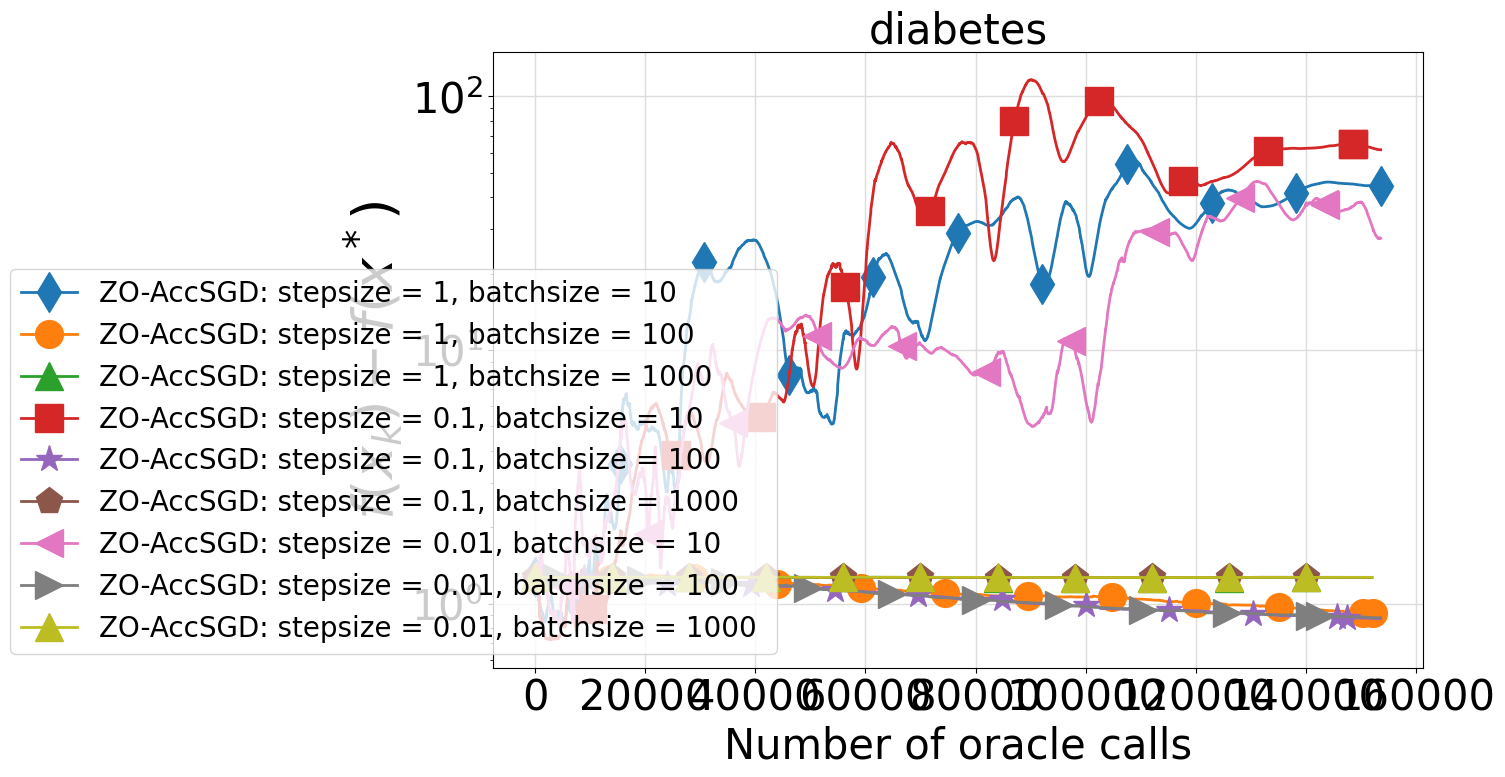

In [15]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1, 1e-1, 1e-2]
batchsizes = [10, 100, 1000]

for step_param in stepsizes:
    for bs in batchsizes: 
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: stepsize = {step_param}, batchsize = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

Easy to see that with params lr = 1e-2 and bs = 1000; lr = 1e-3 and bs = 100 method has the best convergence. Let's enlarge N:

In [16]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [100, 200, 500]:
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished after {} iters with lr = {} and bs = {}'.format(N, step_param, bs))

100%|██████████| 76/76 [00:00<00:00, 156.34it/s]


Finished after 100 iters with lr = 0.01 and bs = 1000


100%|██████████| 153/153 [00:00<00:00, 162.08it/s]


Finished after 200 iters with lr = 0.01 and bs = 1000


100%|██████████| 384/384 [00:02<00:00, 157.64it/s]


Finished after 500 iters with lr = 0.01 and bs = 1000


100%|██████████| 768/768 [00:04<00:00, 189.52it/s]


Finished after 100 iters with lr = 0.001 and bs = 100


100%|██████████| 1536/1536 [00:08<00:00, 191.35it/s]


Finished after 200 iters with lr = 0.001 and bs = 100


100%|██████████| 3840/3840 [00:20<00:00, 183.48it/s]

Finished after 500 iters with lr = 0.001 and bs = 100
CPU times: total: 37 s
Wall time: 36.9 s


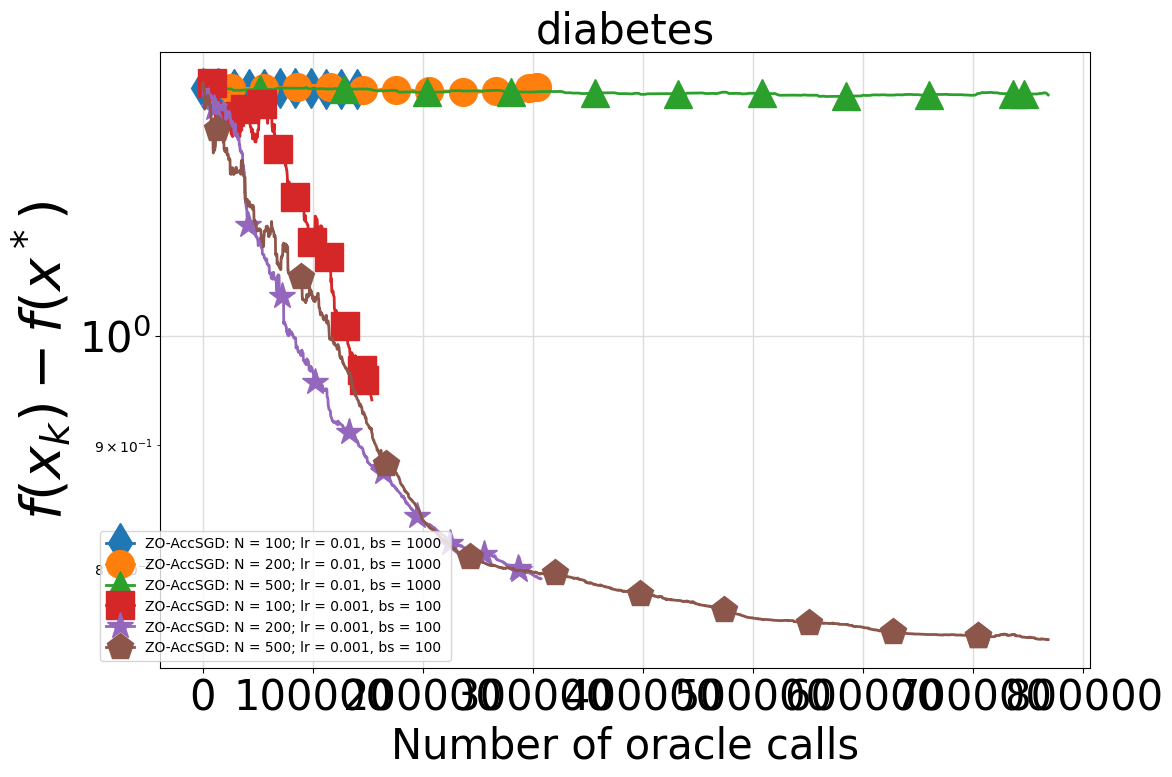

In [17]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-2, 1e-3]
batchsizes = [1000, 100]
for step_param, bs in zip(stepsizes, batchsizes):
    for N in [100, 200, 500]:
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {step_param}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [33]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 200

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 1
x_init[0:num_of_non_zeros] += shift_param
N = 200

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-4
rho = 100
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-4

f(x_0)-f(x^*) =  1.269398056499138


In [14]:
%%time
N = 200
stepsizes = [100, 10, 1, 1e-1, 1e-2]
batchsizes = [10, 100, 1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format((1 / L) * step_param, bs))

100%|██████████| 15360/15360 [01:15<00:00, 204.39it/s]


Finished with lr = 0.011618554662917491 and bs = 10


100%|██████████| 1536/1536 [00:07<00:00, 194.77it/s]


Finished with lr = 0.011618554662917491 and bs = 100


100%|██████████| 153/153 [00:00<00:00, 165.60it/s]


Finished with lr = 0.011618554662917491 and bs = 1000


100%|██████████| 15360/15360 [01:15<00:00, 203.41it/s]


Finished with lr = 0.0011618554662917492 and bs = 10


100%|██████████| 1536/1536 [00:07<00:00, 198.87it/s]


Finished with lr = 0.0011618554662917492 and bs = 100


100%|██████████| 153/153 [00:00<00:00, 160.34it/s]


Finished with lr = 0.0011618554662917492 and bs = 1000


100%|██████████| 15360/15360 [01:14<00:00, 204.93it/s]


Finished with lr = 0.00011618554662917492 and bs = 10


100%|██████████| 1536/1536 [00:07<00:00, 197.70it/s]


Finished with lr = 0.00011618554662917492 and bs = 100


100%|██████████| 153/153 [00:00<00:00, 161.26it/s]


Finished with lr = 0.00011618554662917492 and bs = 1000


100%|██████████| 15360/15360 [01:14<00:00, 205.21it/s]


Finished with lr = 1.1618554662917493e-05 and bs = 10


100%|██████████| 1536/1536 [00:07<00:00, 197.49it/s]


Finished with lr = 1.1618554662917493e-05 and bs = 100


100%|██████████| 153/153 [00:00<00:00, 166.72it/s]


Finished with lr = 1.1618554662917493e-05 and bs = 1000


100%|██████████| 15360/15360 [01:15<00:00, 204.50it/s]


Finished with lr = 1.1618554662917491e-06 and bs = 10


100%|██████████| 1536/1536 [00:07<00:00, 198.50it/s]


Finished with lr = 1.1618554662917491e-06 and bs = 100


100%|██████████| 153/153 [00:00<00:00, 159.45it/s]

Finished with lr = 1.1618554662917491e-06 and bs = 1000
CPU times: total: 7min
Wall time: 6min 59s


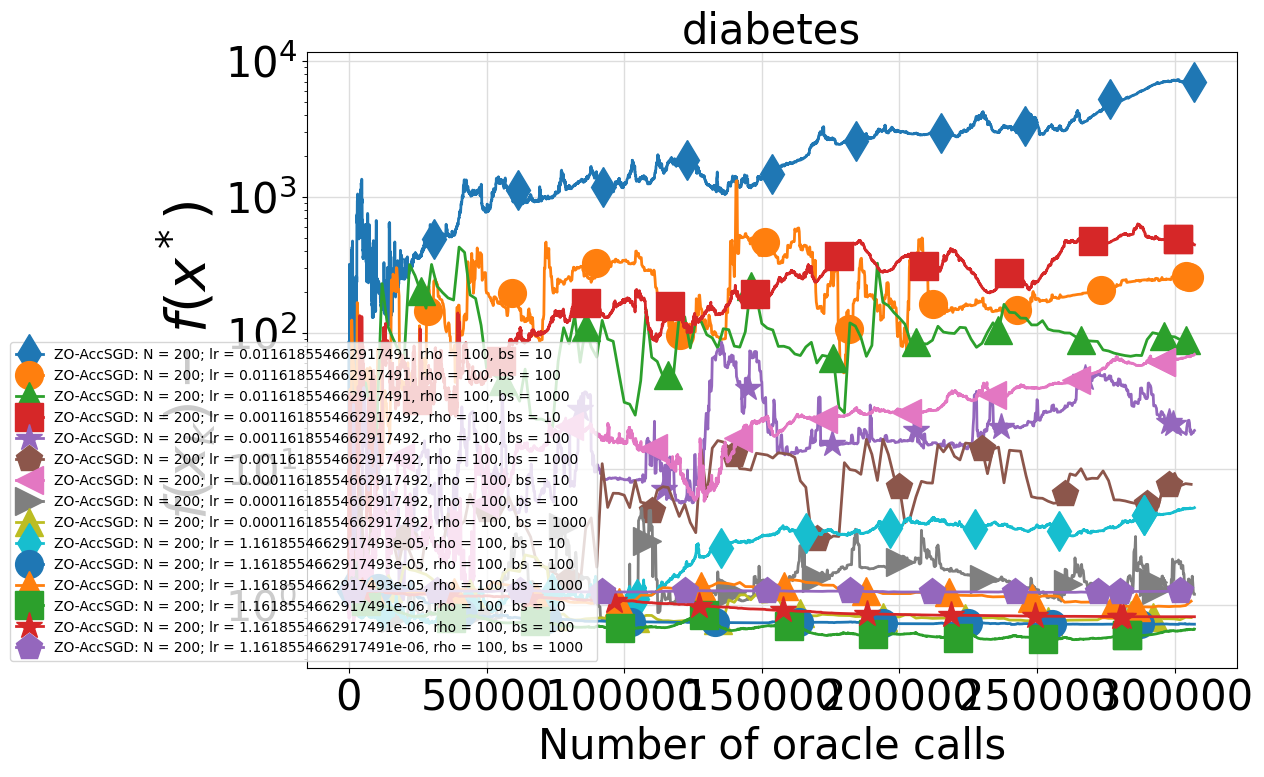

In [17]:
N = 200
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [100, 10, 1, 1e-1, 1e-2]
batchsizes = [10, 100, 1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [20]:
N = 200
stepsizes = [1e-3, 1e-4, 1e-5]
batchsizes = [10, 100, 1000]
rhos = [1, 10, 100, 1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 15360/15360 [01:18<00:00, 195.98it/s]


Finished with lr = 1.1618554662917492e-07, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:15<00:00, 203.01it/s]


Finished with lr = 1.1618554662917492e-07, bs = 10, rho = 10


100%|██████████| 15360/15360 [01:15<00:00, 203.41it/s]


Finished with lr = 1.1618554662917492e-07, bs = 10, rho = 100


100%|██████████| 15360/15360 [01:15<00:00, 203.27it/s]


Finished with lr = 1.1618554662917492e-07, bs = 10, rho = 1000


100%|██████████| 1536/1536 [00:07<00:00, 199.75it/s]


Finished with lr = 1.1618554662917492e-07, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 200.21it/s]


Finished with lr = 1.1618554662917492e-07, bs = 100, rho = 10


100%|██████████| 1536/1536 [00:07<00:00, 198.47it/s]


Finished with lr = 1.1618554662917492e-07, bs = 100, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 200.07it/s]


Finished with lr = 1.1618554662917492e-07, bs = 100, rho = 1000


100%|██████████| 153/153 [00:00<00:00, 166.75it/s]


Finished with lr = 1.1618554662917492e-07, bs = 1000, rho = 1


100%|██████████| 153/153 [00:00<00:00, 169.18it/s]


Finished with lr = 1.1618554662917492e-07, bs = 1000, rho = 10


100%|██████████| 153/153 [00:00<00:00, 170.49it/s]


Finished with lr = 1.1618554662917492e-07, bs = 1000, rho = 100


100%|██████████| 153/153 [00:00<00:00, 170.87it/s]


Finished with lr = 1.1618554662917492e-07, bs = 1000, rho = 1000


100%|██████████| 15360/15360 [01:15<00:00, 204.09it/s]


Finished with lr = 1.1618554662917493e-08, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:15<00:00, 203.73it/s]


Finished with lr = 1.1618554662917493e-08, bs = 10, rho = 10


100%|██████████| 15360/15360 [01:15<00:00, 203.38it/s]


Finished with lr = 1.1618554662917493e-08, bs = 10, rho = 100


100%|██████████| 15360/15360 [01:17<00:00, 198.73it/s]


Finished with lr = 1.1618554662917493e-08, bs = 10, rho = 1000


100%|██████████| 1536/1536 [00:07<00:00, 196.89it/s]


Finished with lr = 1.1618554662917493e-08, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 194.59it/s]


Finished with lr = 1.1618554662917493e-08, bs = 100, rho = 10


100%|██████████| 1536/1536 [00:07<00:00, 195.55it/s]


Finished with lr = 1.1618554662917493e-08, bs = 100, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 197.53it/s]


Finished with lr = 1.1618554662917493e-08, bs = 100, rho = 1000


100%|██████████| 153/153 [00:00<00:00, 166.37it/s]


Finished with lr = 1.1618554662917493e-08, bs = 1000, rho = 1


100%|██████████| 153/153 [00:00<00:00, 159.49it/s]


Finished with lr = 1.1618554662917493e-08, bs = 1000, rho = 10


100%|██████████| 153/153 [00:00<00:00, 160.99it/s]


Finished with lr = 1.1618554662917493e-08, bs = 1000, rho = 100


100%|██████████| 153/153 [00:00<00:00, 166.92it/s]


Finished with lr = 1.1618554662917493e-08, bs = 1000, rho = 1000


100%|██████████| 15360/15360 [01:16<00:00, 200.71it/s]


Finished with lr = 1.1618554662917494e-09, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:16<00:00, 200.55it/s]


Finished with lr = 1.1618554662917494e-09, bs = 10, rho = 10


100%|██████████| 15360/15360 [01:16<00:00, 199.70it/s]


Finished with lr = 1.1618554662917494e-09, bs = 10, rho = 100


100%|██████████| 15360/15360 [01:15<00:00, 202.82it/s]


Finished with lr = 1.1618554662917494e-09, bs = 10, rho = 1000


100%|██████████| 1536/1536 [00:07<00:00, 200.24it/s]


Finished with lr = 1.1618554662917494e-09, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 199.88it/s]


Finished with lr = 1.1618554662917494e-09, bs = 100, rho = 10


100%|██████████| 1536/1536 [00:07<00:00, 199.92it/s]


Finished with lr = 1.1618554662917494e-09, bs = 100, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 200.65it/s]


Finished with lr = 1.1618554662917494e-09, bs = 100, rho = 1000


100%|██████████| 153/153 [00:00<00:00, 169.86it/s]


Finished with lr = 1.1618554662917494e-09, bs = 1000, rho = 1


100%|██████████| 153/153 [00:00<00:00, 164.45it/s]


Finished with lr = 1.1618554662917494e-09, bs = 1000, rho = 10


100%|██████████| 153/153 [00:00<00:00, 167.07it/s]


Finished with lr = 1.1618554662917494e-09, bs = 1000, rho = 100


100%|██████████| 153/153 [00:00<00:00, 170.23it/s]

Finished with lr = 1.1618554662917494e-09, bs = 1000, rho = 1000


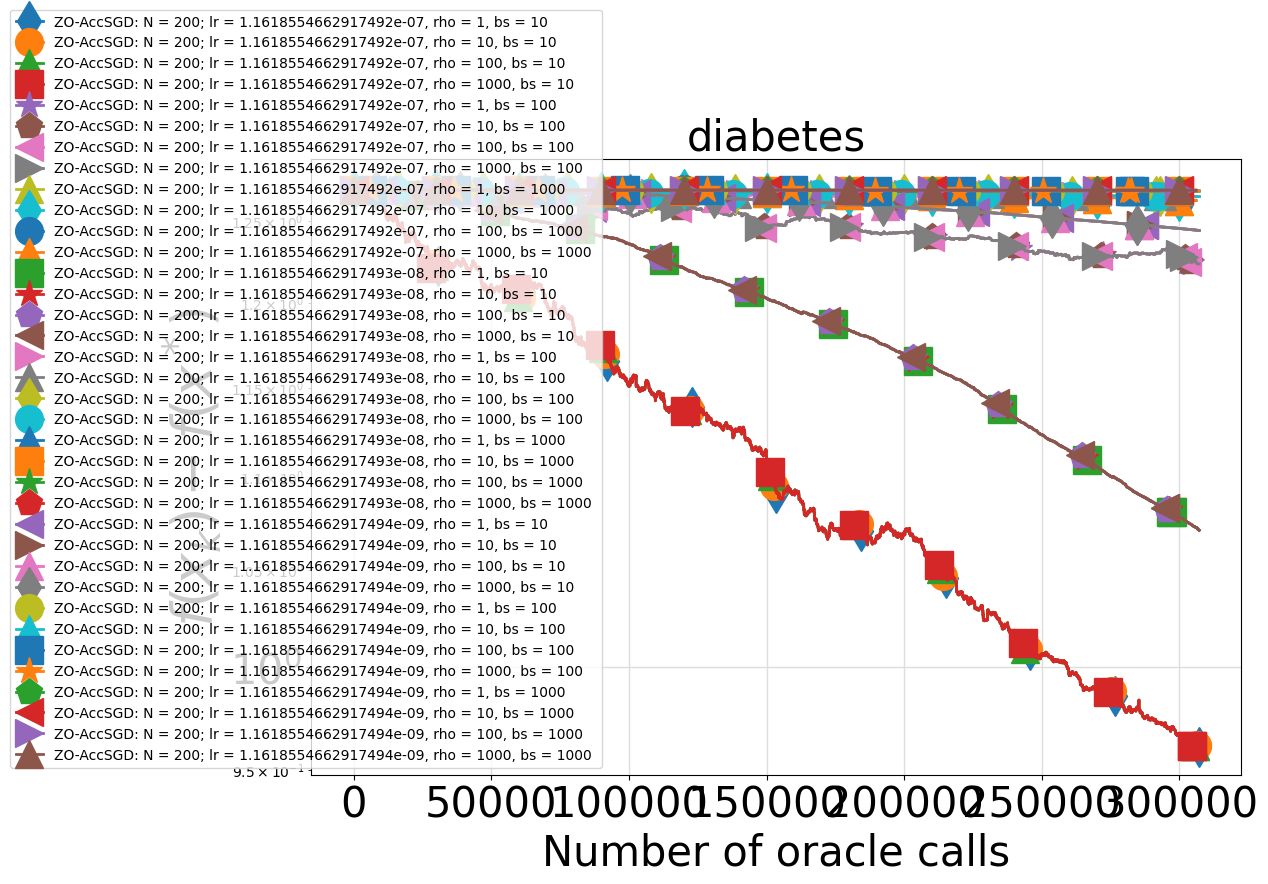

In [32]:
N = 200
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-3, 1e-4, 1e-5]
batchsizes = [10, 100, 1000]
rhos = [1, 10, 100, 1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [41]:
N = 400
stepsizes = [5e-1, 4e-1, 3e-1, 2e-1, 1e-1, 9e-2, 8e-2, 7e-2, 6e-2]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

  0%|          | 7/3072 [00:00<00:43, 69.98it/s]

100%|██████████| 3072/3072 [00:32<00:00, 94.48it/s] 


Finished with lr = 5.809277331458746e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 116.78it/s]


Finished with lr = 4.6474218651669974e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 118.15it/s]


Finished with lr = 3.4855663988752474e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 117.49it/s]


Finished with lr = 2.3237109325834987e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:27<00:00, 113.09it/s]


Finished with lr = 1.1618554662917493e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 116.92it/s]


Finished with lr = 1.0456699196625742e-05, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 116.94it/s]


Finished with lr = 9.294843730333993e-06, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 114.17it/s]


Finished with lr = 8.132988264042245e-06, bs = 100, rho = 100


100%|██████████| 3072/3072 [00:26<00:00, 115.44it/s]

Finished with lr = 6.971132797750495e-06, bs = 100, rho = 100


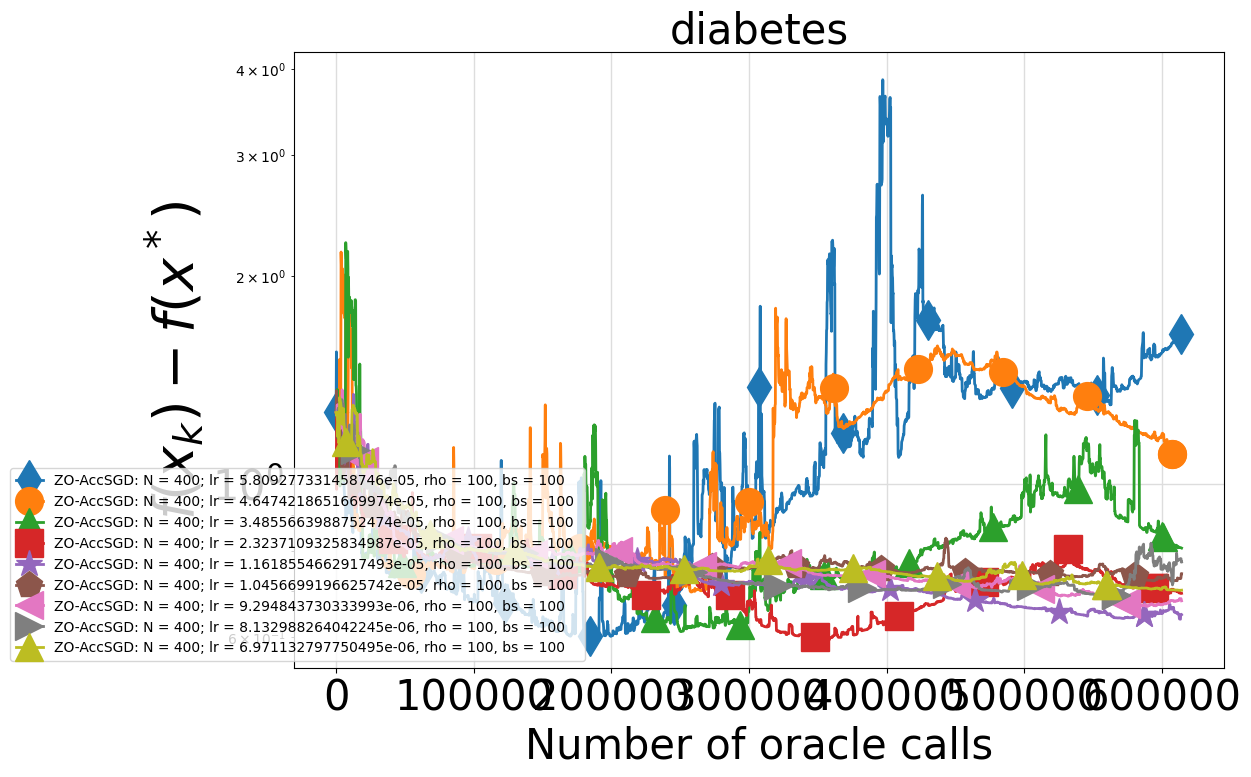

In [42]:
N = 400
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [5e-1, 4e-1, 3e-1, 2e-1, 1e-1, 9e-2, 8e-2, 7e-2, 6e-2]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

B = 100

In [12]:
N = 400
stepsizes = [5e-1, 1e-1, 5e-2, 1e-2, 5e-3]
batchsizes = [1000]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 307/307 [00:45<00:00,  6.78it/s]


Finished with lr = 5.809277331458746e-05, bs = 1000, rho = 100


100%|██████████| 307/307 [00:47<00:00,  6.43it/s]


Finished with lr = 1.1618554662917493e-05, bs = 1000, rho = 100


100%|██████████| 307/307 [00:46<00:00,  6.66it/s]


Finished with lr = 5.809277331458747e-06, bs = 1000, rho = 100


100%|██████████| 307/307 [00:45<00:00,  6.69it/s]


Finished with lr = 1.1618554662917491e-06, bs = 1000, rho = 100


100%|██████████| 307/307 [00:44<00:00,  6.88it/s]

Finished with lr = 5.809277331458746e-07, bs = 1000, rho = 100


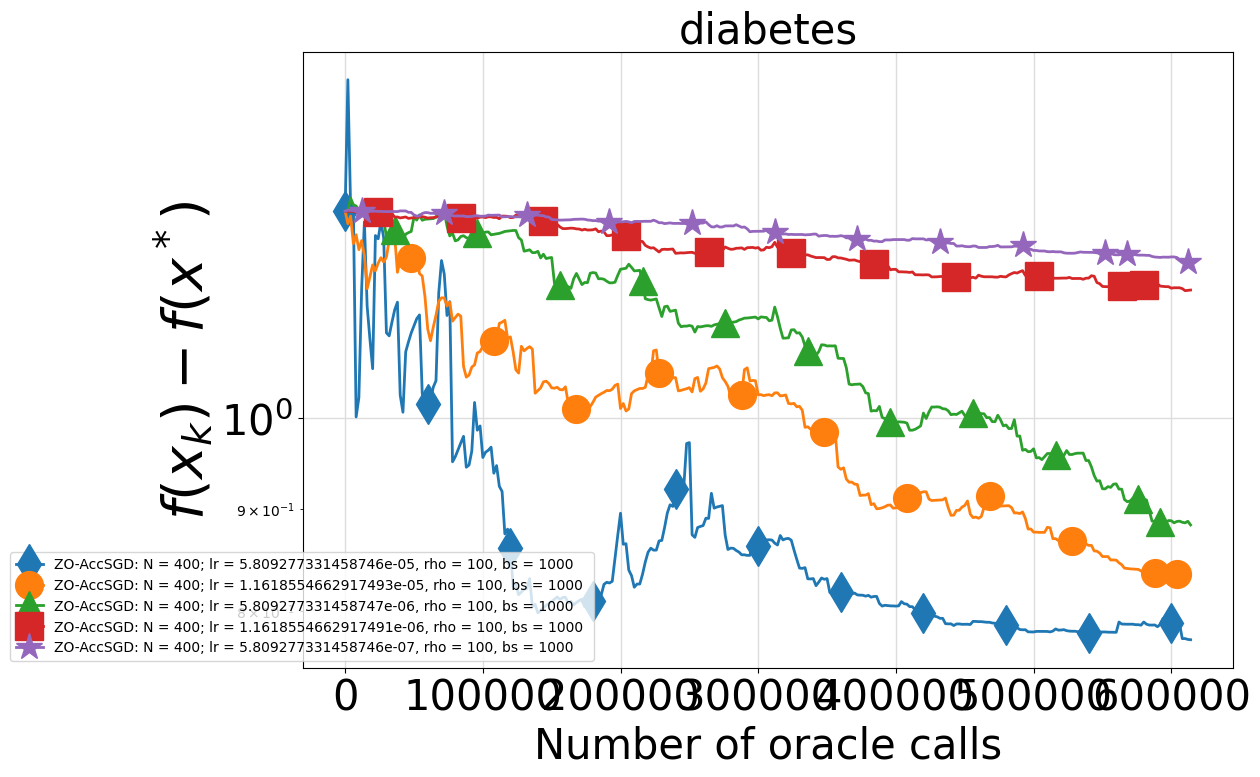

In [14]:
N = 400
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [5e-1, 1e-1, 5e-2, 1e-2, 5e-3]
batchsizes = [1000]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [34]:
N = 500
stepsizes = [1e-2, 1e-3]
batchsizes = [5, 10, 20]
rhos = [1, 100, 10000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 76800/76800 [06:27<00:00, 197.97it/s]


Finished with lr = 1.1618554662917491e-06, bs = 5, rho = 1


100%|██████████| 76800/76800 [06:25<00:00, 199.16it/s]


Finished with lr = 1.1618554662917491e-06, bs = 5, rho = 100


100%|██████████| 76800/76800 [06:24<00:00, 199.75it/s]


Finished with lr = 1.1618554662917491e-06, bs = 5, rho = 10000


100%|██████████| 38400/38400 [03:14<00:00, 197.26it/s]


Finished with lr = 1.1618554662917491e-06, bs = 10, rho = 1


100%|██████████| 38400/38400 [03:15<00:00, 196.78it/s]


Finished with lr = 1.1618554662917491e-06, bs = 10, rho = 100


100%|██████████| 38400/38400 [03:15<00:00, 196.55it/s]


Finished with lr = 1.1618554662917491e-06, bs = 10, rho = 10000


100%|██████████| 19200/19200 [01:39<00:00, 192.67it/s]


Finished with lr = 1.1618554662917491e-06, bs = 20, rho = 1


100%|██████████| 19200/19200 [01:39<00:00, 192.12it/s]


Finished with lr = 1.1618554662917491e-06, bs = 20, rho = 100


100%|██████████| 19200/19200 [01:39<00:00, 192.40it/s]


Finished with lr = 1.1618554662917491e-06, bs = 20, rho = 10000


  4%|▍         | 2968/76800 [00:15<06:22, 192.90it/s]


KeyboardInterrupt: 

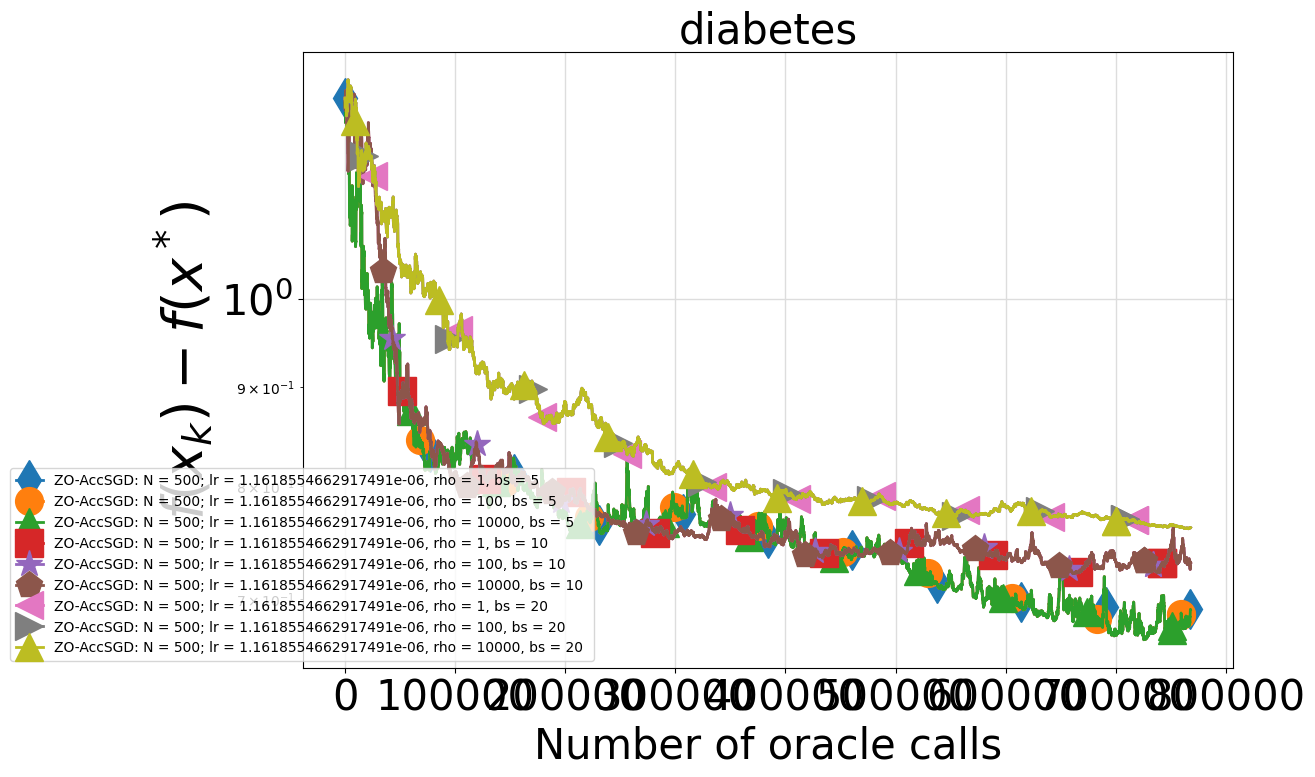

In [35]:
methods = []
N = 500
stepsizes = [1e-2]
batchsizes = [5, 10, 20]
rhos = [1, 100, 10000]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [14]:
N = 10
stepsizes = [1, 0.9, 0.8, 0.7]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

  5%|▌         | 4/76 [00:19<05:54,  4.93s/it]


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'dump/diabetes_init_first_1_shift_1Our_algorithm1_epochs_10_delta_0_batch_100.txt'

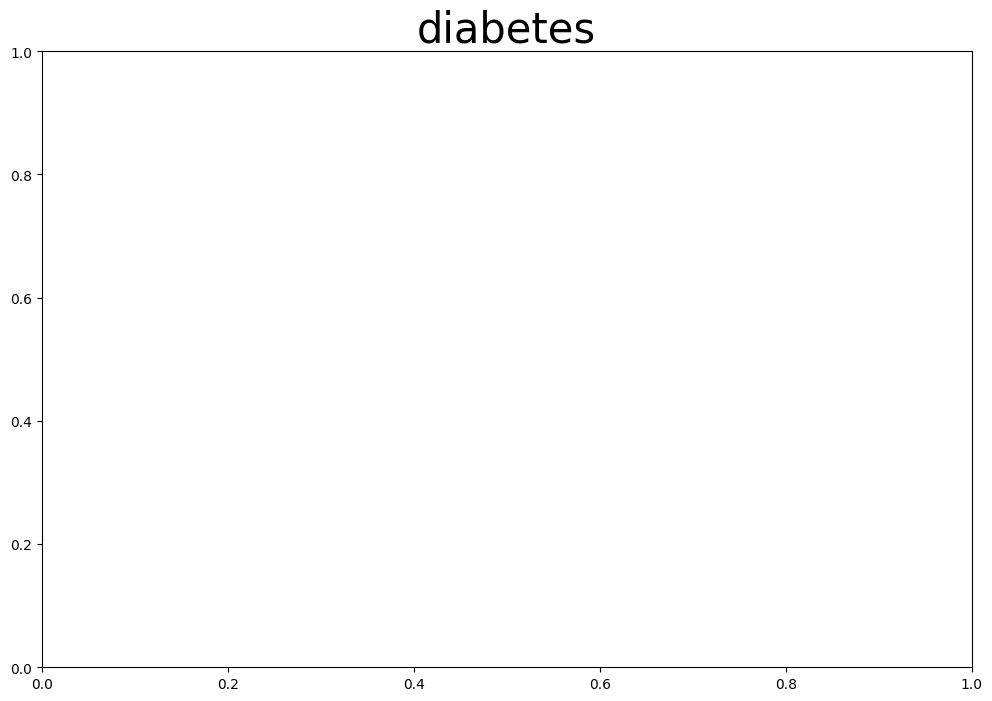

In [ ]:
N = 10
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1, 0.9, 0.8, 0.7]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

B = 10000

In [15]:
N = 10
stepsizes = [1, 0.9, 0.8, 0.7]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 76/76 [06:14<00:00,  4.93s/it]


Finished with lr = 0.00011618554662917492, bs = 100, rho = 100


100%|██████████| 76/76 [06:11<00:00,  4.89s/it]


Finished with lr = 0.00010456699196625743, bs = 100, rho = 100


100%|██████████| 76/76 [06:11<00:00,  4.89s/it]


Finished with lr = 9.294843730333995e-05, bs = 100, rho = 100


100%|██████████| 76/76 [06:10<00:00,  4.88s/it]

Finished with lr = 8.132988264042244e-05, bs = 100, rho = 100


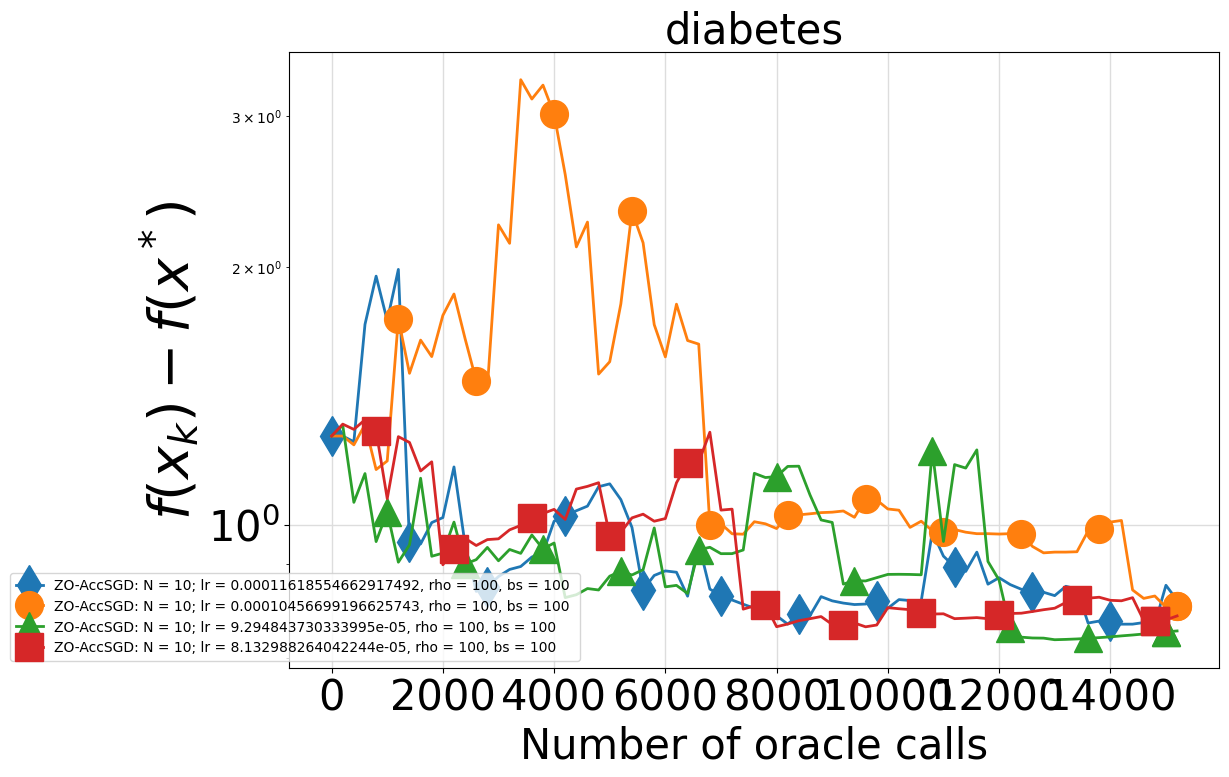

In [16]:
N = 10
rho = 100
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1, 0.9, 0.8, 0.7]
batchsizes = [100]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

$B = 10^5$

In [17]:
N = 20
stepsizes = [1, 0.5, 1e-1]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, t]
            Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
            print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 30/30 [25:56<00:00, 51.89s/it]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 30/30 [25:40<00:00, 51.35s/it]


Finished with lr = 5.809277331458746e-05, bs = 500, rho = 100


100%|██████████| 30/30 [25:34<00:00, 51.15s/it]

Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


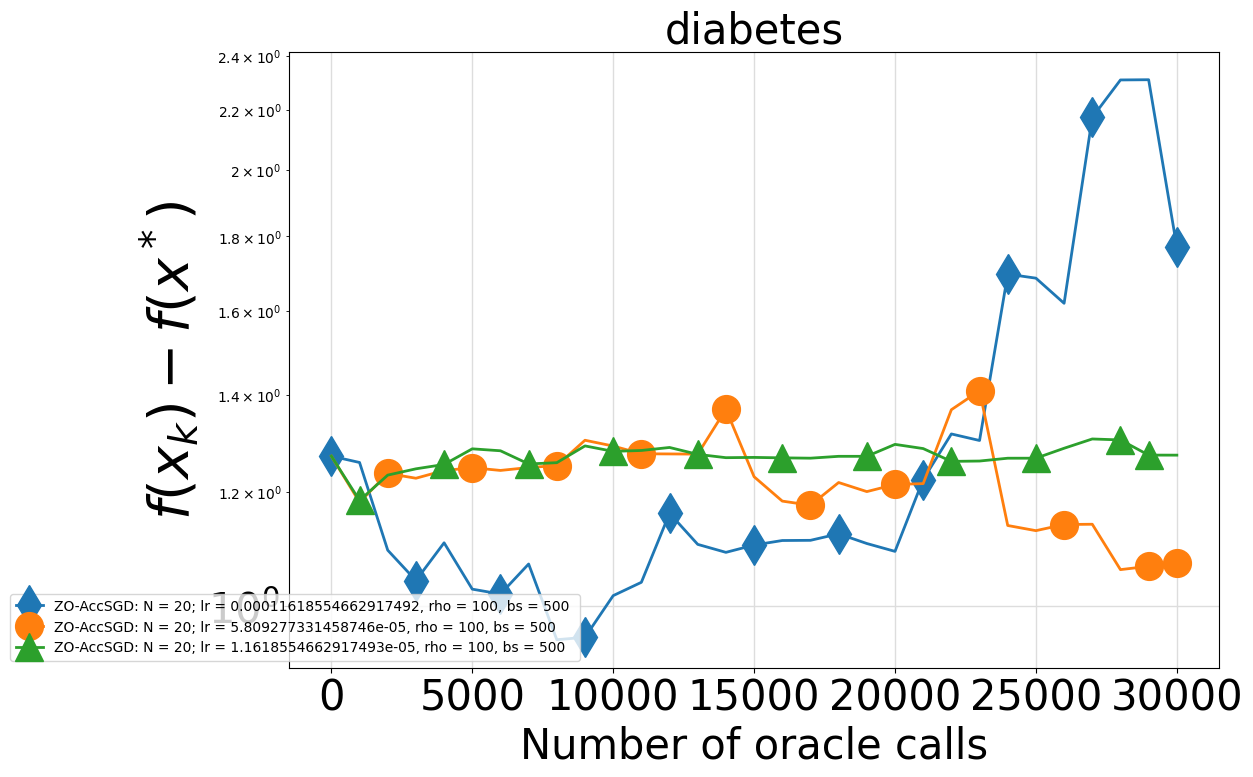

In [18]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
N = 20
stepsizes = [1, 0.5, 1e-1]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for bs in batchsizes: 
        for rho in rhos:
            methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [12]:
N = 100
stepsizes = [1, 1e-1, 1e-2, 1e-3]
Bs = [1, 10, 100, 1000, 10000]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, B, t]
                Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                    f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
                print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 153/153 [00:00<00:00, 1334.49it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 180.04it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 153/153 [00:08<00:00, 17.86it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 153/153 [01:20<00:00,  1.89it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 153/153 [13:16<00:00,  5.20s/it]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 1545.00it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 187.52it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 153/153 [00:07<00:00, 19.30it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 153/153 [01:17<00:00,  1.98it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 153/153 [13:13<00:00,  5.19s/it]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 1378.08it/s]


Finished with lr = 1.1618554662917491e-06, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 180.79it/s]


Finished with lr = 1.1618554662917491e-06, bs = 500, rho = 100


100%|██████████| 153/153 [00:08<00:00, 18.37it/s]


Finished with lr = 1.1618554662917491e-06, bs = 500, rho = 100


100%|██████████| 153/153 [01:20<00:00,  1.91it/s]


Finished with lr = 1.1618554662917491e-06, bs = 500, rho = 100


100%|██████████| 153/153 [13:22<00:00,  5.25s/it]


Finished with lr = 1.1618554662917491e-06, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 1353.80it/s]


Finished with lr = 1.1618554662917492e-07, bs = 500, rho = 100


100%|██████████| 153/153 [00:00<00:00, 180.48it/s]


Finished with lr = 1.1618554662917492e-07, bs = 500, rho = 100


100%|██████████| 153/153 [00:08<00:00, 18.80it/s]


Finished with lr = 1.1618554662917492e-07, bs = 500, rho = 100


100%|██████████| 153/153 [01:20<00:00,  1.89it/s]


Finished with lr = 1.1618554662917492e-07, bs = 500, rho = 100


100%|██████████| 153/153 [13:20<00:00,  5.23s/it]

Finished with lr = 1.1618554662917492e-07, bs = 500, rho = 100


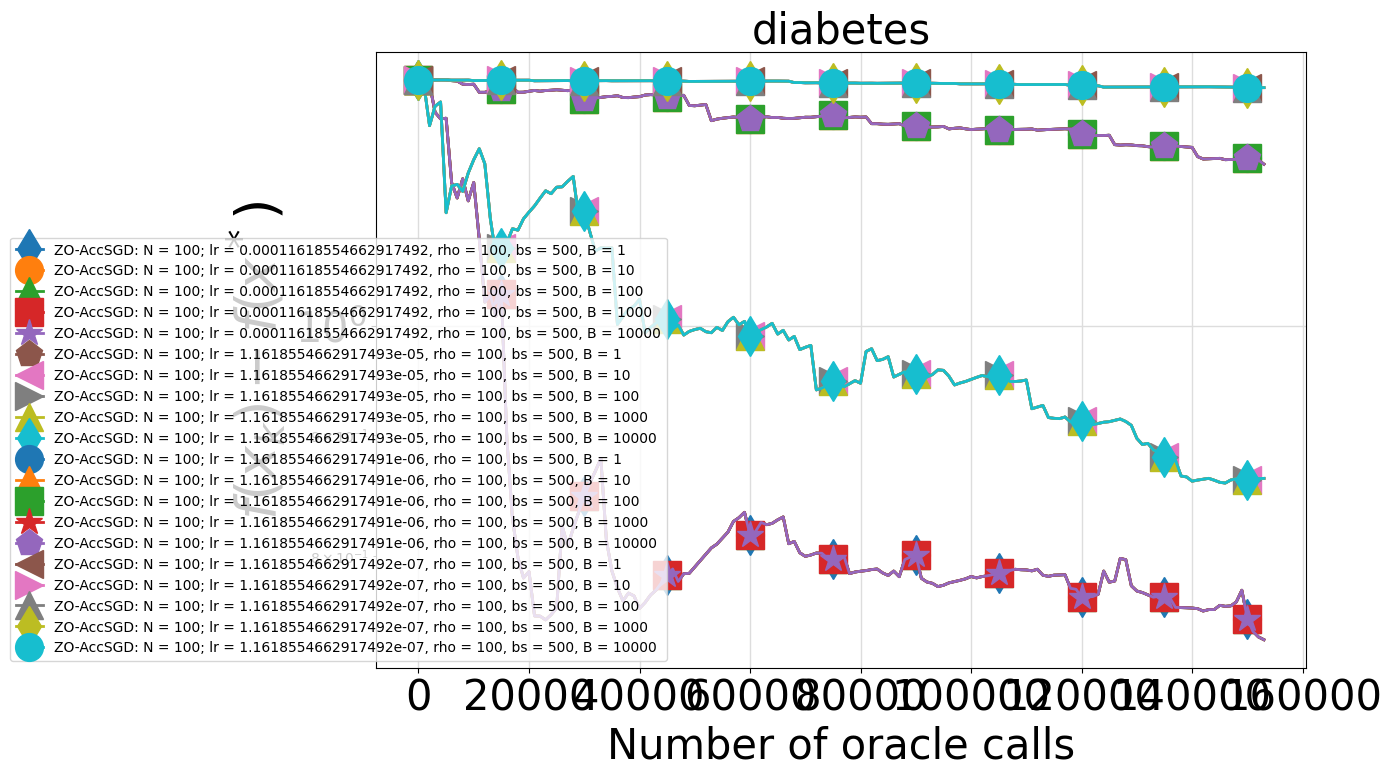

In [13]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
N = 100
stepsizes = [1, 1e-1, 1e-2, 1e-3]
Bs = [1, 10, 100, 1000, 10000]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                            f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs}, B = {B}", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [12]:
N = 200
stepsizes = [1, 1e-1]
Bs = [1, 1000, 100000]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, B, t]
                Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                    f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
                print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 307/307 [00:00<00:00, 1356.93it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 307/307 [02:48<00:00,  1.82it/s]


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 307/307 [4:24:33<00:00, 51.71s/it]  


Finished with lr = 0.00011618554662917492, bs = 500, rho = 100


100%|██████████| 307/307 [00:00<00:00, 1410.35it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 307/307 [02:39<00:00,  1.93it/s]


Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


100%|██████████| 307/307 [4:22:09<00:00, 51.24s/it]  

Finished with lr = 1.1618554662917493e-05, bs = 500, rho = 100


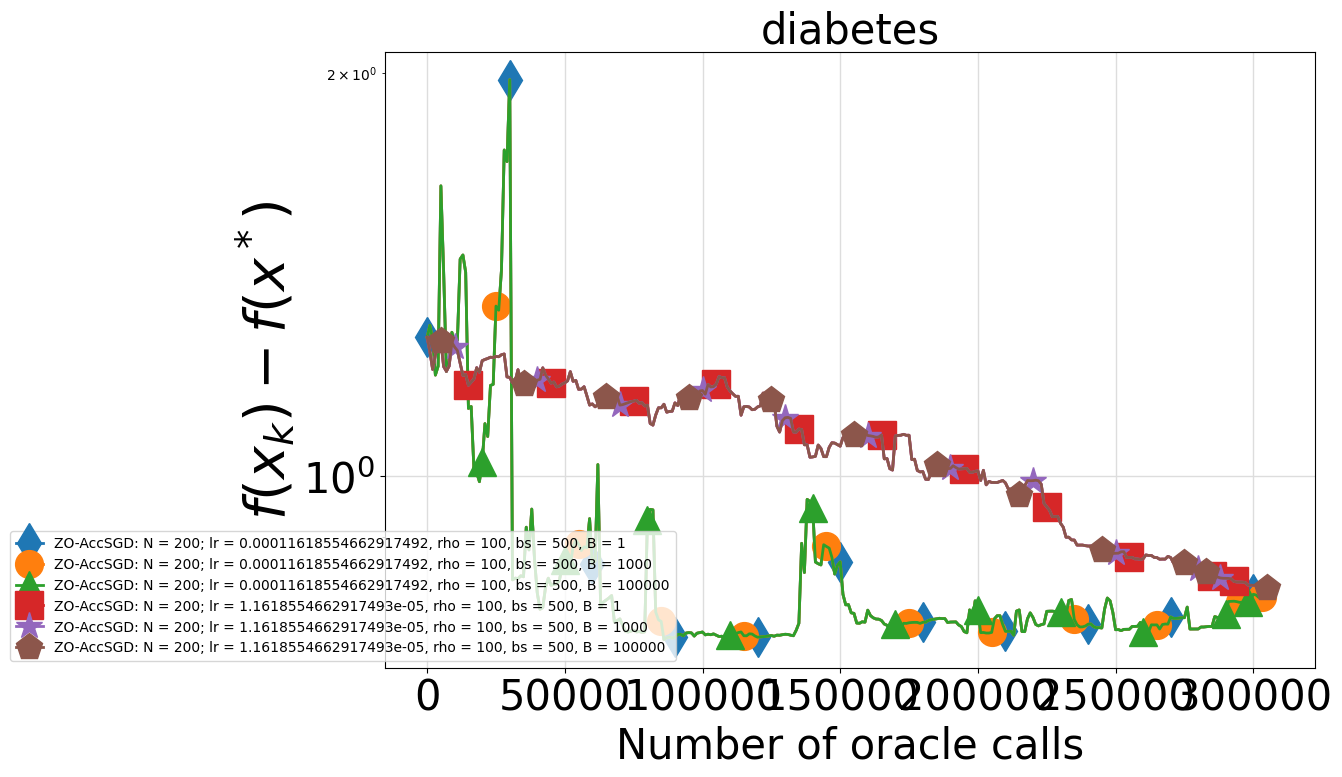

In [13]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
N = 200
stepsizes = [1, 1e-1]
Bs = [1, 1000, 100000]
batchsizes = [500]
rhos = [100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                            f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs}, B = {B}", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [13]:
N = 200
stepsizes = [1, 5e-1, 1e-1]
Bs = [1, 10]
batchsizes = [1, 10, 100]
rhos = [1, 100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, B, t]
                Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                    f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
                print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 153600/153600 [01:21<00:00, 1882.31it/s]


Finished with lr = 0.00011618554662917492, bs = 1, rho = 1


100%|██████████| 153600/153600 [01:19<00:00, 1932.49it/s]


Finished with lr = 0.00011618554662917492, bs = 1, rho = 100


100%|██████████| 15360/15360 [00:09<00:00, 1540.20it/s]


Finished with lr = 0.00011618554662917492, bs = 10, rho = 1


100%|██████████| 15360/15360 [00:09<00:00, 1630.86it/s]


Finished with lr = 0.00011618554662917492, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:00<00:00, 1604.82it/s]


Finished with lr = 0.00011618554662917492, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:00<00:00, 1626.85it/s]


Finished with lr = 0.00011618554662917492, bs = 100, rho = 100


100%|██████████| 153600/153600 [12:25<00:00, 206.05it/s]


Finished with lr = 0.00011618554662917492, bs = 1, rho = 1


100%|██████████| 153600/153600 [12:09<00:00, 210.62it/s]


Finished with lr = 0.00011618554662917492, bs = 1, rho = 100


100%|██████████| 15360/15360 [01:15<00:00, 203.15it/s]


Finished with lr = 0.00011618554662917492, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:15<00:00, 202.87it/s]


Finished with lr = 0.00011618554662917492, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 199.37it/s]


Finished with lr = 0.00011618554662917492, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 202.24it/s]


Finished with lr = 0.00011618554662917492, bs = 100, rho = 100


100%|██████████| 153600/153600 [01:19<00:00, 1935.57it/s]


Finished with lr = 5.809277331458746e-05, bs = 1, rho = 1


100%|██████████| 153600/153600 [01:19<00:00, 1932.86it/s]


Finished with lr = 5.809277331458746e-05, bs = 1, rho = 100


100%|██████████| 15360/15360 [00:09<00:00, 1579.08it/s]


Finished with lr = 5.809277331458746e-05, bs = 10, rho = 1


100%|██████████| 15360/15360 [00:09<00:00, 1638.69it/s]


Finished with lr = 5.809277331458746e-05, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:00<00:00, 1636.04it/s]


Finished with lr = 5.809277331458746e-05, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:00<00:00, 1637.94it/s]


Finished with lr = 5.809277331458746e-05, bs = 100, rho = 100


100%|██████████| 153600/153600 [12:07<00:00, 211.19it/s]


Finished with lr = 5.809277331458746e-05, bs = 1, rho = 1


100%|██████████| 153600/153600 [12:07<00:00, 211.07it/s]


Finished with lr = 5.809277331458746e-05, bs = 1, rho = 100


100%|██████████| 15360/15360 [01:15<00:00, 203.36it/s]


Finished with lr = 5.809277331458746e-05, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:14<00:00, 205.43it/s]


Finished with lr = 5.809277331458746e-05, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 200.85it/s]


Finished with lr = 5.809277331458746e-05, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 201.79it/s]


Finished with lr = 5.809277331458746e-05, bs = 100, rho = 100


100%|██████████| 153600/153600 [01:19<00:00, 1940.37it/s]


Finished with lr = 1.1618554662917493e-05, bs = 1, rho = 1


100%|██████████| 153600/153600 [01:20<00:00, 1912.11it/s]


Finished with lr = 1.1618554662917493e-05, bs = 1, rho = 100


100%|██████████| 15360/15360 [00:09<00:00, 1589.98it/s]


Finished with lr = 1.1618554662917493e-05, bs = 10, rho = 1


100%|██████████| 15360/15360 [00:09<00:00, 1628.24it/s]


Finished with lr = 1.1618554662917493e-05, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:00<00:00, 1650.87it/s]


Finished with lr = 1.1618554662917493e-05, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:00<00:00, 1636.82it/s]


Finished with lr = 1.1618554662917493e-05, bs = 100, rho = 100


100%|██████████| 153600/153600 [12:07<00:00, 211.03it/s]


Finished with lr = 1.1618554662917493e-05, bs = 1, rho = 1


100%|██████████| 153600/153600 [12:07<00:00, 211.19it/s]


Finished with lr = 1.1618554662917493e-05, bs = 1, rho = 100


100%|██████████| 15360/15360 [01:15<00:00, 203.61it/s]


Finished with lr = 1.1618554662917493e-05, bs = 10, rho = 1


100%|██████████| 15360/15360 [01:15<00:00, 204.59it/s]


Finished with lr = 1.1618554662917493e-05, bs = 10, rho = 100


100%|██████████| 1536/1536 [00:07<00:00, 201.10it/s]


Finished with lr = 1.1618554662917493e-05, bs = 100, rho = 1


100%|██████████| 1536/1536 [00:07<00:00, 199.33it/s]

Finished with lr = 1.1618554662917493e-05, bs = 100, rho = 100


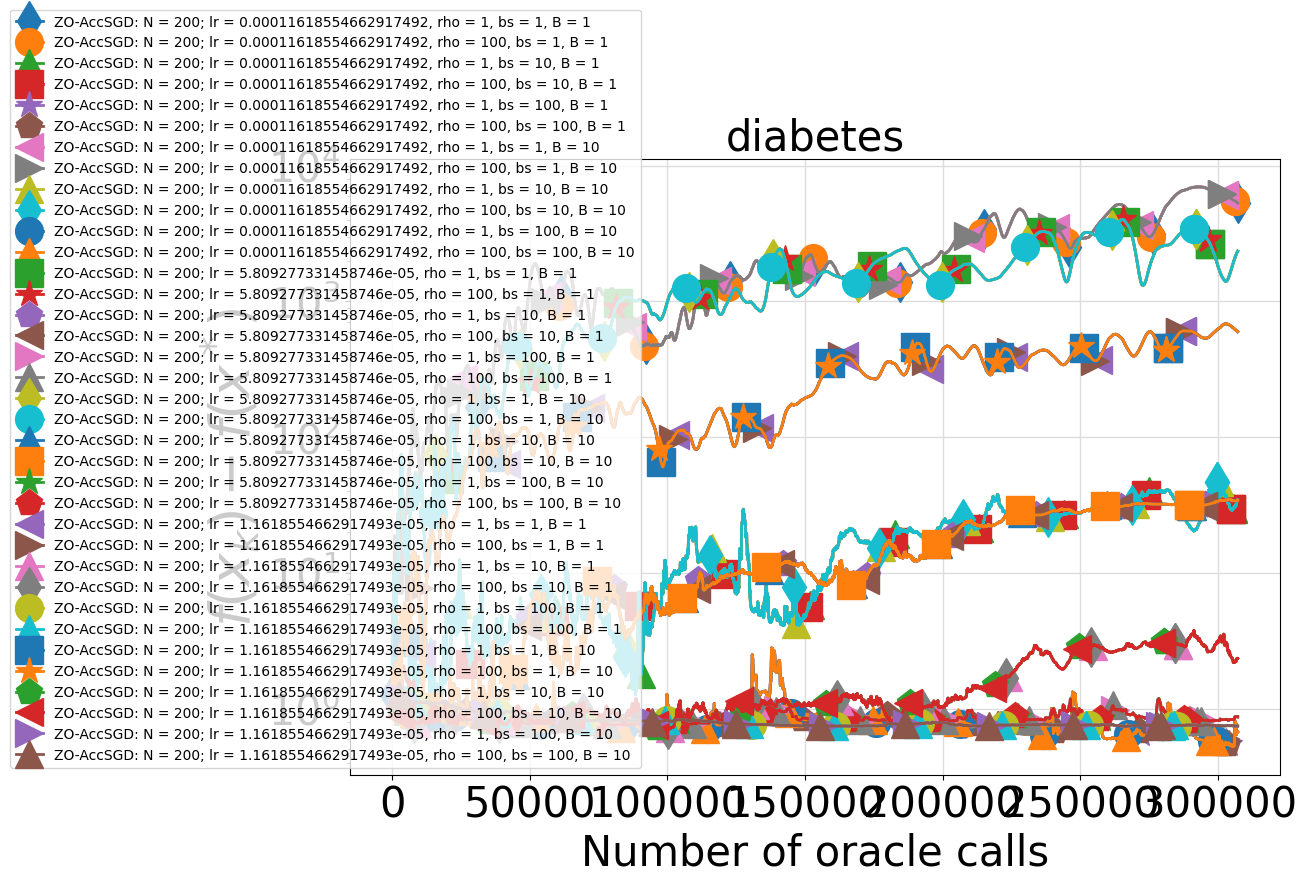

In [14]:
methods = []
N = 200
stepsizes = [1, 5e-1, 1e-1]
Bs = [1, 10]
batchsizes = [1, 10, 100]
rhos = [1, 100]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                            f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs}, B = {B}", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [17]:
N = 100
stepsizes = [1, 1e-1, 1e-2, 1e-3]
Bs = [100]
batchsizes = [1]
rhos = [1]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, rho, B, t]
                Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                                    f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
                print('Finished with lr = {}, bs = {}, rho = {}'.format((1 / L) * step_param, bs, rho))

100%|██████████| 76800/76800 [59:38<00:00, 21.46it/s] 


Finished with lr = 0.00011618554662917492, bs = 1, rho = 1


100%|██████████| 76800/76800 [59:35<00:00, 21.48it/s] 


Finished with lr = 1.1618554662917493e-05, bs = 1, rho = 1


100%|██████████| 76800/76800 [59:27<00:00, 21.53it/s] 


Finished with lr = 1.1618554662917491e-06, bs = 1, rho = 1


100%|██████████| 76800/76800 [59:21<00:00, 21.57it/s] 

Finished with lr = 1.1618554662917492e-07, bs = 1, rho = 1


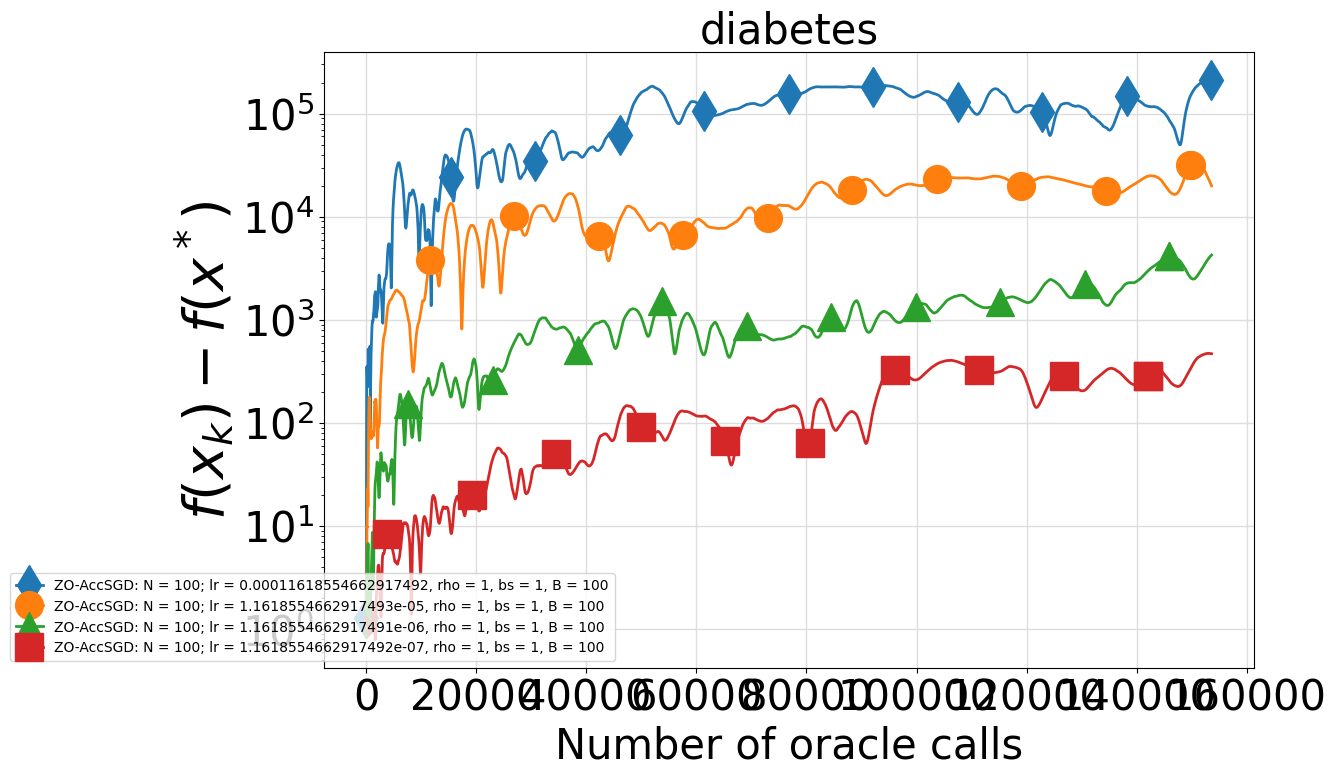

In [18]:
methods = []
N = 100
stepsizes = [1, 1e-1, 1e-2, 1e-3]
Bs = [100]
batchsizes = [1]
rhos = [1]
for step_param in stepsizes:
    for B in Bs:
        for bs in batchsizes: 
            for rho in rhos:
                methods.append(['Our_algorithm logreg', [step_param, N, delta, bs],
                            f"ZO-AccSGD: N = {N}; lr = {(1 / L) * step_param}, rho = {rho}, bs = {bs}, B = {B}", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)